In [4]:
import numpy as np

a = np.arange(10)         # shape (10,)
b = np.arange(4) * 2      # shape (4,)

result = a[:, None] * b   # shape (10, 4
result

array([[ 0,  0,  0,  0],
       [ 0,  2,  4,  6],
       [ 0,  4,  8, 12],
       [ 0,  6, 12, 18],
       [ 0,  8, 16, 24],
       [ 0, 10, 20, 30],
       [ 0, 12, 24, 36],
       [ 0, 14, 28, 42],
       [ 0, 16, 32, 48],
       [ 0, 18, 36, 54]])

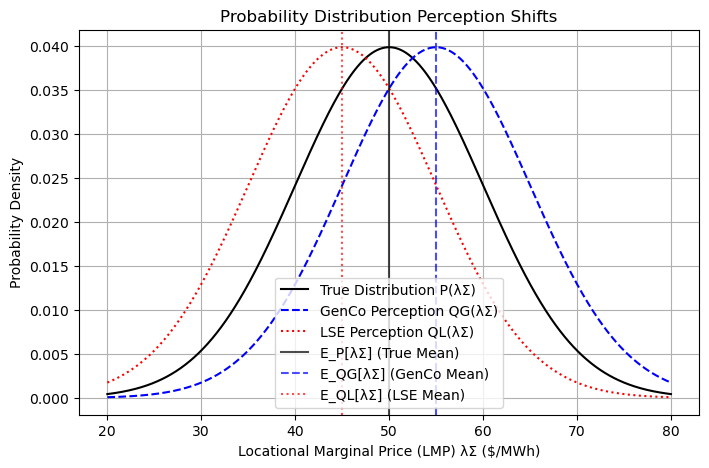

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define the true probability distribution (Normal Distribution for LMP)
mu_true = 50  # True mean
sigma = 10    # Standard deviation

# Define biased distributions
K_G = 5   # Shift for GenCo
K_L = -5  # Shift for LSE

# Generate x values
x = np.linspace(20, 80, 1000)

# Compute probability densities
pdf_true = stats.norm.pdf(x, mu_true, sigma)       # True distribution
pdf_genco = stats.norm.pdf(x, mu_true + K_G, sigma)  # Shifted for GenCo
pdf_lse = stats.norm.pdf(x, mu_true + K_L, sigma)   # Shifted for LSE

# Plot the distributions
plt.figure(figsize=(8, 5))
plt.plot(x, pdf_true, label="True Distribution P(λΣ)", color='black')
plt.plot(x, pdf_genco, label="GenCo Perception QG(λΣ)", color='blue', linestyle='dashed')
plt.plot(x, pdf_lse, label="LSE Perception QL(λΣ)", color='red', linestyle='dotted')

# Add vertical lines to show mean shifts
plt.axvline(mu_true, color='black', linestyle='solid', alpha=0.7, label="E_P[λΣ] (True Mean)")
plt.axvline(mu_true + K_G, color='blue', linestyle='dashed', alpha=0.7, label="E_QG[λΣ] (GenCo Mean)")
plt.axvline(mu_true + K_L, color='red', linestyle='dotted', alpha=0.7, label="E_QL[λΣ] (LSE Mean)")

# Labels and legend
plt.xlabel("Locational Marginal Price (LMP) λΣ ($/MWh)")
plt.ylabel("Probability Density")
plt.title("Probability Distribution Perception Shifts")
plt.legend()
plt.grid()


In [1]:
import numpy as np

# Define parameters
mean_V = 100
mean_P = 20
sigma_V = 10
sigma_P = 5
rho = 0.7  # desired correlation
samples = 10000

# Covariance matrix
cov_matrix = [
    [sigma_V**2, rho * sigma_V * sigma_P],
    [rho * sigma_V * sigma_P, sigma_P**2]
]

# Generate correlated data
data = np.random.multivariate_normal(
    [mean_V, mean_P],
    cov_matrix,
    samples
)

V_simulated = data[:, 0]
P_simulated = data[:, 1]

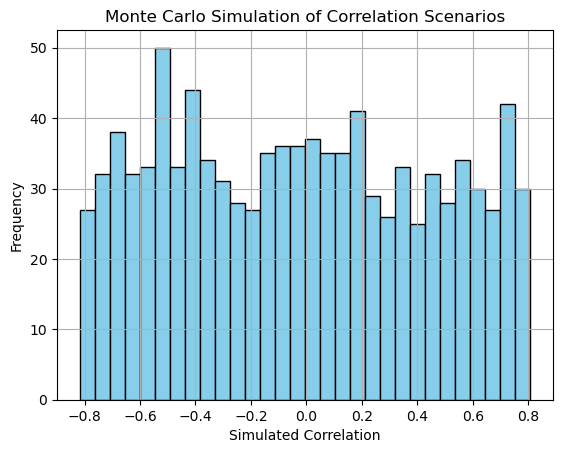

In [5]:
# Parameters
import matplotlib.pyplot as plt

mean_V, sigma_V = 100, 10
mean_P, sigma_P = 20, 5

# Define correlation scenarios (e.g., uniformly between -0.8 and 0.8)
M = 1000  # number of scenarios
N = 500   # number of samples per scenario
rho_scenarios = np.random.uniform(-0.8, 0.8, M)

# Storage for resulting correlations
simulated_rhos = []

for rho in rho_scenarios:
    cov_matrix = [
        [sigma_V**2, rho * sigma_V * sigma_P],
        [rho * sigma_V * sigma_P, sigma_P**2]
    ]

    # Simulate multivariate normal samples
    data = np.random.multivariate_normal(
        [mean_V, mean_P],
        cov_matrix,
        N
    )

    V_sim, P_sim = data[:,0], data[:,1]

    # Calculate empirical correlation
    sim_rho = np.corrcoef(V_sim, P_sim)[0,1]
    simulated_rhos.append(sim_rho)

# Plot distribution of simulated correlation scenarios
plt.hist(simulated_rhos, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Simulated Correlation')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation of Correlation Scenarios')
plt.grid(True)
plt.show()

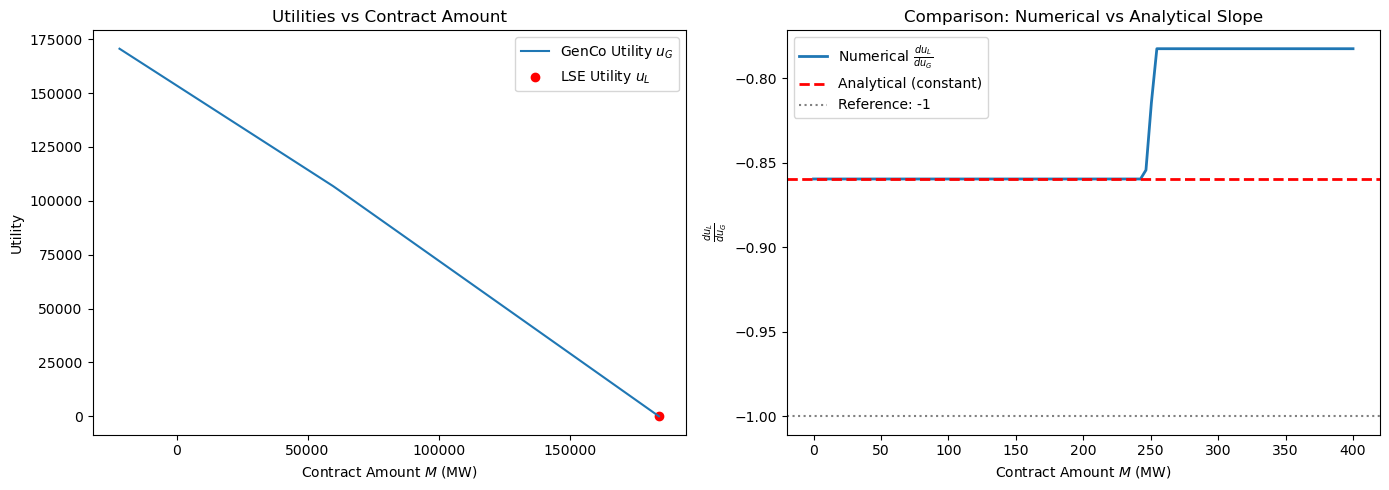

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- PARAMETERS ---
T = 24  # Contract length in hours
strike_price = 10  # $/MWh
AG = 0.5  # GenCo risk aversion
AL = 0.7  # LSE risk aversion
PG = 250  # GenCo fixed production
KG = 40   # GenCo price bias
KL = -20  # LSE price bias
alpha = 0.95  # CVaR confidence level
M_range = np.linspace(0, 400, 100)  # Contract amounts (MW)

# --- Simulate λ_t time series: num_samples x T
np.random.seed(42)
num_samples = 1000
lambda_samples = np.random.normal(loc=30, scale=5, size=(num_samples, T))
lambda_sum = np.sum(lambda_samples, axis=1)  # λ_Σ per scenario

# --- CVaR calculation ---
def cvar(values, alpha=0.95, tail="right"):
    sorted_vals = np.sort(values)
    cutoff = int((1 - alpha) * len(sorted_vals))
    if tail == "right":
        return np.mean(sorted_vals[-cutoff:])
    else:
        return np.mean(sorted_vals[:cutoff])

# --- Utilities + Numerical Derivatives ---
uG_list = []
uL_list = []

uG_list_2 = []
uL_list_2 = []

for M in M_range:
    # Generator and Load revenues
    piG = PG * (lambda_sum+KG) + (T * strike_price - (lambda_sum+KG)) * M
    piL = ((lambda_sum+KL) - T * strike_price) * M

    # Utility for GenCo
    EG_piG = np.mean(piG)
    CVaR_piG = cvar(piG, alpha=alpha, tail="left")
    uG = (1 - AG) * EG_piG + AG * CVaR_piG

    # Utility for LSE
    EL_piL = np.mean(piL)
    CVaR_piL = cvar(piL, alpha=alpha, tail="left")
    uL = (1 - AL) * EL_piL + AL * CVaR_piL

    uG_list.append(uG)
    uL_list.append(uL)

uG_array = np.array(uG_list)
uL_array = np.array(uL_list)

# --- Numerical Derivative duL/duG ---
duG_dM = np.gradient(uG_array, M_range)
duL_dM = np.gradient(uL_array, M_range)
duL_duG_numeric = duL_dM / duG_dM

# --- Analytical Gradient from Your Formula ---
def analytical_duL_duG(AG, AL, E_lambda, CVaR_lambda, CVaR_neg_lambda, KG, KL, S, T):
    dEG_dM = T * S - E_lambda - KG
    dCVaR_G_dM = -CVaR_lambda - KG + T * S
    duG_dM = (1 - AG) * dEG_dM + AG * dCVaR_G_dM

    dEL_dM = E_lambda + KL - T * S
    dCVaR_L_dM = CVaR_lambda + KL - T * S
    duL_dM = (1 - AL) * dEL_dM + AL * dCVaR_L_dM

    return duL_dM / duG_dM

# Compute inputs for analytical slope
E_lambda = np.mean(lambda_sum)
CVaR_lambda = cvar(lambda_sum, alpha=alpha, tail="left")
CVaR_neg_lambda = cvar(lambda_sum, alpha=alpha, tail="left")
duL_duG_analytical = analytical_duL_duG(AG, AL, E_lambda, CVaR_lambda, CVaR_neg_lambda, KG, KL, strike_price, T)

# --- PLOT ---
plt.figure(figsize=(14, 5))

# Plot utilities
plt.subplot(1, 2, 1)
plt.plot(uG_array,uL_array , label="GenCo Utility $u_G$")
plt.scatter(uG_array[0], uL_array[0], label="LSE Utility $u_L$", color='red')
plt.xlabel("Contract Amount $M$ (MW)")
plt.ylabel("Utility")
plt.title("Utilities vs Contract Amount")
plt.legend()

# Plot gradient comparison
plt.subplot(1, 2, 2)
plt.plot(M_range, duL_duG_numeric, label="Numerical $\\frac{du_L}{du_G}$", lw=2)
plt.axhline(duL_duG_analytical, color="r", linestyle="--", label="Analytical (constant)", lw=2)
plt.axhline(-1, color="gray", linestyle=":", label="Reference: -1")
plt.xlabel("Contract Amount $M$ (MW)")
plt.ylabel("$\\frac{du_L}{du_G}$")
plt.title("Comparison: Numerical vs Analytical Slope")
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
import numpy as np

# --- Parameters ---
T = 24
S = 30.0
alpha = 0.95
num_samples = 100000
epsilon = 1.0
M_value = 250.0

# --- Joint Distribution: mean and covariance ---
mean = [720, 240]  # [E[lambda_sum], E[P_G]]
std_lambda = 50
std_pg = 10
rho = 0.3  # Correlation coefficient

cov_matrix = [
    [std_lambda**2, rho * std_lambda * std_pg],
    [rho * std_lambda * std_pg, std_pg**2]
]

# --- Generate Correlated Samples ---
np.random.seed(1)
samples = np.random.multivariate_normal(mean, cov_matrix, size=num_samples)
lambda_samples = samples[:, 0]
pg_samples = samples[:, 1]

# --- Profit Function ---
def piG_samples(M):
    return lambda_samples * (pg_samples - M) + T * S * M

# --- CVaR Computation ---
def cvar(samples, alpha=0.95):
    sorted_vals = np.sort(samples)
    cutoff = int((1 - alpha) * len(sorted_vals))
    return np.mean(sorted_vals[:cutoff])

# --- Derivative via Central Difference ---
def cvar_derivative_wrt_M(M, epsilon=1.0):
    pi_plus = piG_samples(M + epsilon)
    pi_minus = piG_samples(M - epsilon)
    cvar_plus = cvar(pi_plus, alpha)
    cvar_minus = cvar(pi_minus, alpha)
    return (cvar_plus - cvar_minus) / (2 * epsilon)

# --- Results ---
cvar_val = cvar(piG_samples(M_value), alpha)
cvar_deriv = cvar_derivative_wrt_M(M_value, epsilon)

print(f"CVaR(π_G) at M = {M_value:.1f} is: {cvar_val:.2f}")
print(f"d(CVaR)/dM at M = {M_value:.1f} is: {cvar_deriv:.2f}")


CVaR(π_G) at M = 250.0 is: 158810.25
d(CVaR)/dM at M = 250.0 is: 13.56


In [34]:
import numpy as np

# --- PARAMETERS ---
T = 24
S = 30.0
alpha = 0.95
AG = 0.5
AL = 0.6
KG = 15.0   # GenCo bias
KL = -10.0  # LSE bias
M_value = 250.0
epsilon = 1.0
num_samples = 100_000

# --- SIMULATE CORRELATED lambda_sum and P_G ---
np.random.seed(0)
mean = [720, 240]
std_lambda = 50
std_pg = 10
rho = 0.7

cov = [
    [std_lambda**2, rho * std_lambda * std_pg],
    [rho * std_lambda * std_pg, std_pg**2]
]

samples = np.random.multivariate_normal(mean, cov, size=num_samples)
lambda_samples = samples[:, 0]       # unbiased lambda
pg_samples = samples[:, 1]           # production

# --- APPLY BIAS TO LAMBDA SAMPLES ---
lambda_G = lambda_samples + KG  # GenCo's view of lambda
lambda_L = lambda_samples + KL  # LSE's view of lambda

# --- PAYOFF FUNCTIONS WITH BIASED LAMBDA ---
def piG(M):
    return lambda_G * (pg_samples - M) + T * S * M

def piL(M):
    return (lambda_L - T * S) * M

# --- CVaR (left-tail) ---
def cvar(samples, alpha=0.95):
    sorted_vals = np.sort(samples)
    cutoff = int((1 - alpha) * len(sorted_vals))
    return np.mean(sorted_vals[:cutoff])

# --- UTILITIES ---
def uG(M):
    pi = piG(M)
    return (1 - AG) * np.mean(pi) + AG * cvar(pi, alpha)

def uL(M):
    pi = piL(M)
    return (1 - AL) * np.mean(pi) + AL * cvar(pi, alpha)

# --- NUMERICAL DERIVATIVES ---
duG_dM = (uG(M_value + epsilon) - uG(M_value - epsilon)) / (2 * epsilon)
duL_dM = (uL(M_value + epsilon) - uL(M_value - epsilon)) / (2 * epsilon)
duL_duG_numeric = duL_dM / duG_dM

# --- d(CVaR)/dM ESTIMATION ---
dCVaR_G_dM = (cvar(piG(M_value + epsilon)) - cvar(piG(M_value - epsilon))) / (2 * epsilon)
dCVaR_L_dM = (cvar(piL(M_value + epsilon)) - cvar(piL(M_value - epsilon))) / (2 * epsilon)

# --- EXPECTATIONS (of biased samples) ---
E_lambda_G = np.mean(lambda_G)
E_lambda_L = np.mean(lambda_L)

# --- THEORETICAL EXPRESSION (with sample bias) ---
numerator = (1 - AL) * (E_lambda_L - T * S) + AL * dCVaR_L_dM
denominator = (1 - AG) * (-E_lambda_G + T * S) + AG * dCVaR_G_dM
duL_duG_theoretical = numerator / denominator

# --- RESULTS ---
print("----- Results (Bias in Lambda Samples) -----")
print(f"Numerical duL/duG:          {duL_duG_numeric:.4f}")
print(f"Theoretical duL/duG (★):    {duL_duG_theoretical:.4f}")
print()
print(f"GenCo dCVaR/dM:             {dCVaR_G_dM:.4f}")
print(f"LSE   dCVaR/dM:             {dCVaR_L_dM:.4f}")
print(f"GenCo E[lambda]:            {E_lambda_G:.4f}")
print(f"LSE   E[lambda]:            {E_lambda_L:.4f}")


----- Results (Bias in Lambda Samples) -----
Numerical duL/duG:          -4.9046
Theoretical duL/duG (★):    -4.9046

GenCo dCVaR/dM:             44.3770
LSE   dCVaR/dM:             -113.4363
GenCo E[lambda]:            734.9896
LSE   E[lambda]:            709.9896


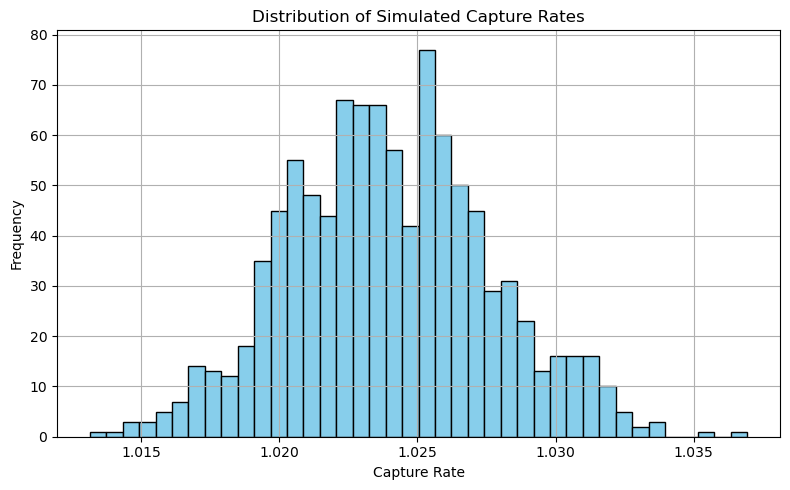

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
T = 168        # Time steps (e.g., one week of hourly data)
N = 1000       # Number of Monte Carlo scenarios

# Define statistical properties
mu_price = 50        # Mean price (€/MWh)
mu_volume = 100      # Mean volume (MW)
sigma_price = 10     # Std dev of price
sigma_volume = 20    # Std dev of volume
rho = 0.6            # Correlation between price and volume

# Build covariance matrix
cov_matrix = np.array([
    [sigma_price**2, rho * sigma_price * sigma_volume],
    [rho * sigma_price * sigma_volume, sigma_volume**2]
])
mean_vector = [mu_price, mu_volume]

# Step 1: Generate (T * N) multivariate samples
samples = np.random.multivariate_normal(mean=mean_vector, cov=cov_matrix, size=T * N)

# Step 2: Reshape into (T, N, 2) and split
samples = samples.reshape(T, N, 2)
price_scenarios = samples[:, :, 0]
volume_scenarios = samples[:, :, 1]

# Step 3: Compute statistics per scenario
mu_P = np.mean(price_scenarios, axis=0)
mu_V = np.mean(volume_scenarios, axis=0)
sigma_P = np.std(price_scenarios, axis=0, ddof=1)
sigma_V = np.std(volume_scenarios, axis=0, ddof=1)
rho_scenarios = np.array([
    np.corrcoef(price_scenarios[:, i], volume_scenarios[:, i])[0, 1]
    for i in range(N)
])

# Step 4: Compute capture rate using the formula
capture_rate = 1 + (rho_scenarios * sigma_P * sigma_V) / (mu_P * mu_V)

# Step 5: Organize into DataFrame
scenario_df = pd.DataFrame({
    "mu_P": mu_P,
    "mu_V": mu_V,
    "sigma_P": sigma_P,
    "sigma_V": sigma_V,
    "rho": rho_scenarios,
    "capture_rate": capture_rate
})

# Optional: Plot histogram of capture rates
plt.figure(figsize=(8, 5))
plt.hist(capture_rate, bins=40, color='skyblue', edgecolor='black')
plt.title("Distribution of Simulated Capture Rates")
plt.xlabel("Capture Rate")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
irr_sample = np.random.normal(irradiance_mean, irradiance_std)
irradiance_mean.shape

(24,)

P50 total energy (24 months): 2805.22 MWh
P90 total energy (24 months): 2683.29 MWh


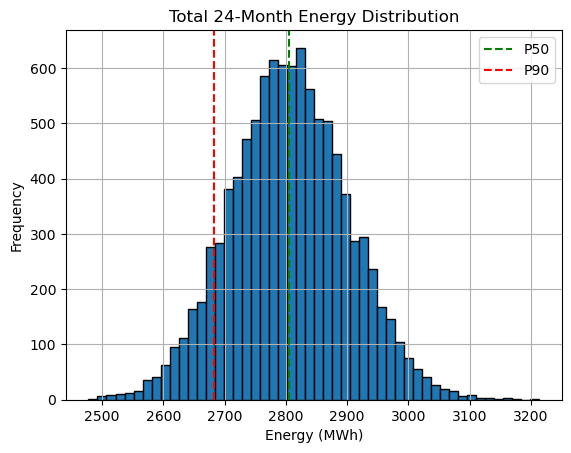

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
N_ITER = 10000         # Number of Monte Carlo simulations
SYSTEM_SIZE = 1000     # kW (1 MWp system)
PR_MEAN = 0.75
PR_STD = 0.02

# Monthly irradiance data (kWh/m²/month)
irradiance_mean = np.array([
    90, 110, 150, 170, 200, 220,
    230, 210, 180, 140, 100, 80,
    95, 115, 145, 165, 195, 215,
    225, 205, 175, 135, 105, 85
])
irradiance_std = irradiance_mean * 0.1  # 10% standard deviation

# Preallocate results
monthly_energy = np.zeros((N_ITER, 24))

for i in range(N_ITER):
    # Sample monthly irradiance and PR
    irr_sample = np.random.normal(irradiance_mean, irradiance_std)
    pr_sample = np.random.normal(PR_MEAN, PR_STD)

    # Ensure no negative values
    irr_sample = np.maximum(irr_sample, 0)
    pr_sample = np.clip(pr_sample, 0.6, 0.9)

    # Energy = Irradiance * System Size * PR / 1000 -> MWh
    monthly_energy[i, :] = irr_sample * SYSTEM_SIZE * pr_sample / 1000

# Aggregate energy
annual_energy = monthly_energy[:, :12].sum(axis=1)
second_year_energy = monthly_energy[:, 12:].sum(axis=1)
total_2y_energy = annual_energy + second_year_energy

# Summary stats
P50 = np.percentile(total_2y_energy, 50)
P90 = np.percentile(total_2y_energy, 10)

print(f"P50 total energy (24 months): {P50:.2f} MWh")
print(f"P90 total energy (24 months): {P90:.2f} MWh")

# Optional: visualize
plt.hist(total_2y_energy, bins=50, edgecolor='black')
plt.axvline(P50, color='green', linestyle='--', label='P50')
plt.axvline(P90, color='red', linestyle='--', label='P90')
plt.title("Total 24-Month Energy Distribution")
plt.xlabel("Energy (MWh)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

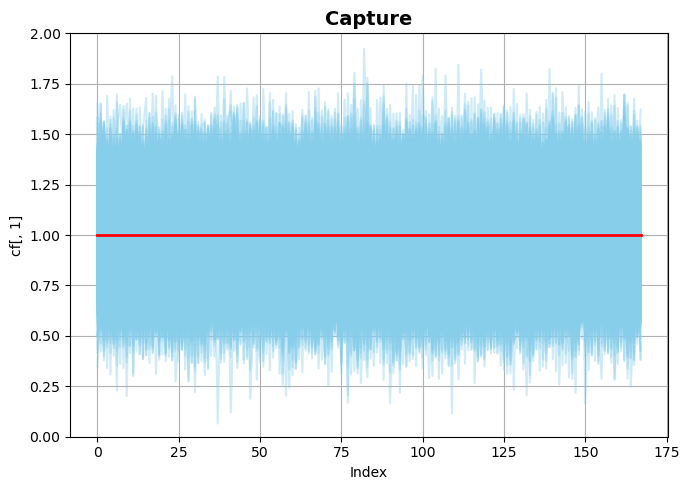

In [17]:
# T x S arrays
P = price_scenarios
V = volume_scenarios  # Stochastic, bounded by V_max (e.g., 100 MW)
P_avg_t = P.mean(axis=1)  # T,

# Pointwise capture rate: shape (T, S)
CR_ts = P / P_avg_t[:, None]

# Aggregated capture rate per scenario (volume-weighted)
numerator = np.sum(P * V, axis=0)  # shape (S,)
denominator = np.sum(P_avg_t[:, None] * V, axis=0)  # shape (S,)
CR_scenario = numerator / denominator  # shape (S,)
V_max = 100  # Example max capacity in MW
capacity_factor = V / V_max  # (T, S)
mean_CF_per_scenario = capacity_factor.mean(axis=0)  # shape (S,)

# Scatter plot: capture rate vs capacity factor
import matplotlib.pyplot as plt


# Step 2: Compute pointwise capture rate matrix (T, S)
P_avg_t = price_scenarios.mean(axis=1)  # (T,)
CR_ts = price_scenarios / P_avg_t[:, None]  # (T, S)

# Step 3: Plot
plt.figure(figsize=(7, 5))
for s in range(N):
    plt.plot(CR_ts[:, s], color='skyblue', alpha=0.4)
plt.plot(CR_ts.mean(axis=1), color='red', linewidth=2)
plt.title("Capture", fontsize=14, weight='bold')
plt.ylabel("cf[, 1]")
plt.xlabel("Index")
plt.ylim(0, 2)
plt.grid(True)
plt.tight_layout()
plt.show()



In [22]:
# Parameters
alpha = 0.95
N = 100000  # Number of samples
M = 100  # Fixed value

# Sample generation (example distributions)
P_G_samples = np.random.normal(loc=120, scale=10, size=N)  # Example: Normal distribution
lambda_samples = np.random.lognormal(mean=4.5, sigma=0.2, size=N)  # Example: Log-normal distribution

# Compute the product
X_samples = (P_G_samples - M) * lambda_samples

# Sort the samples
X_sorted = np.sort(X_samples)

# Calculate VaR
k = int(np.floor(alpha * N))
VaR_alpha = X_sorted[k]

# Calculate CVaR
CVaR_alpha = X_sorted[k:].mean()

print(f"Estimated VaR at level {alpha}: {VaR_alpha}")
print(f"Estimated CVaR at level {alpha}: {CVaR_alpha}")

Estimated VaR at level 0.95: 3596.561000084887
Estimated CVaR at level 0.95: 4191.997613372837


In [13]:
test = np.array([10, 24, 34, 24, 15])
mspace = np.linspace(1, 5, 5)
test[mspace== 2]

array([24])

In [15]:
np.linspace(5, 1, 5)

array([5., 4., 3., 2., 1.])

C:\Users\ande7\AppData\Local\Temp\ipykernel_10328\1463981638.py:32: UserWarning: Glyph 120021 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ande7\anaconda3\envs\optimization\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 120021 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


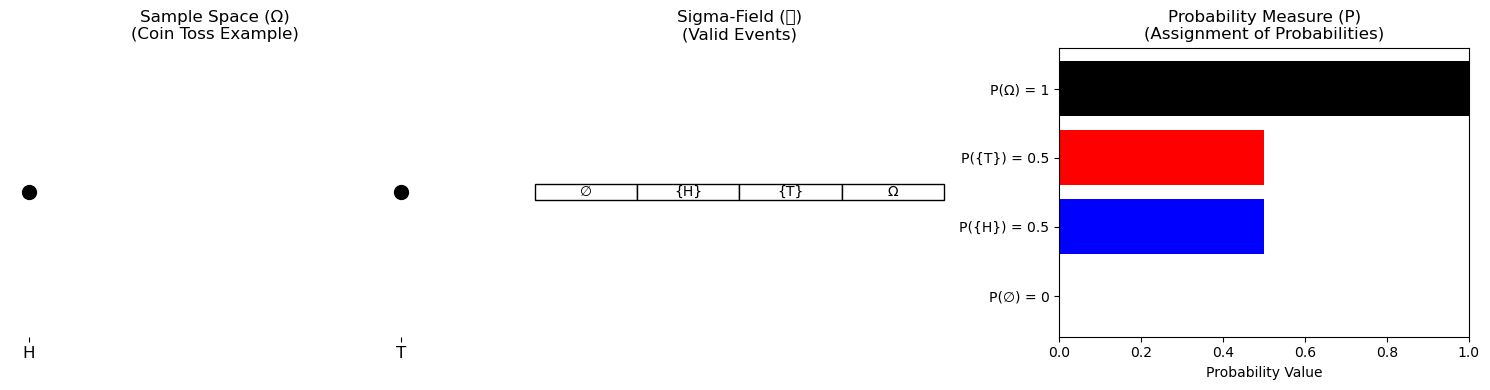

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Sample Space Visualization
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Sample Space (Ω)
omega = ['H', 'T']
ax[0].scatter(omega, [1, 1], color='black', s=100)
ax[0].set_xticks(range(len(omega)))
ax[0].set_xticklabels(omega, fontsize=12)
ax[0].set_yticks([])
ax[0].set_title("Sample Space (Ω)\n(Coin Toss Example)")
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

# Sigma-Field (F)
sigma_field = [["∅", "{H}", "{T}", "Ω"]]
ax[1].table(cellText=sigma_field, loc="center", cellLoc='center')
ax[1].axis("off")
ax[1].set_title("Sigma-Field (𝓕)\n(Valid Events)")

# Probability Measure (P)
event_labels = ["P(∅) = 0", "P({H}) = 0.5", "P({T}) = 0.5", "P(Ω) = 1"]
ax[2].barh(event_labels, [0, 0.5, 0.5, 1], color=['gray', 'blue', 'red', 'black'])
ax[2].set_xlim(0, 1)
ax[2].set_xlabel("Probability Value")
ax[2].set_title("Probability Measure (P)\n(Assignment of Probabilities)")

plt.tight_layout()
plt.show()

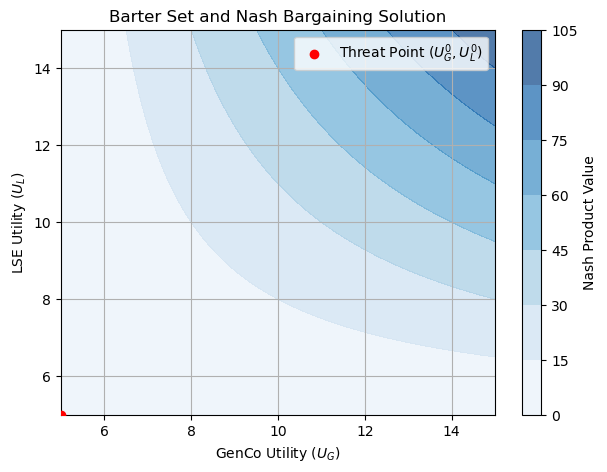

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the threat point (worst-case scenario utilities)
U_G0, U_L0 = 5, 5  # Arbitrary threat point values

# Generate a barter set (random feasible utility pairs above the threat point)
U_G = np.linspace(U_G0, 15, 100)
U_L = np.linspace(U_L0, 15, 100)
U_G_grid, U_L_grid = np.meshgrid(U_G, U_L)

# Define Nash Product (objective function to be maximized in bargaining)
Nash_Product = (U_G_grid - U_G0) * (U_L_grid - U_L0)

# Plot the barter set region
plt.figure(figsize=(7, 5))
plt.contourf(U_G_grid, U_L_grid, Nash_Product, cmap="Blues", alpha=0.7)  # Feasible region
plt.colorbar(label="Nash Product Value")

# Mark threat point
plt.scatter(U_G0, U_L0, color='red', label="Threat Point $(U_G^0, U_L^0)$", zorder=3)

# Annotate key elements
plt.xlabel("GenCo Utility $(U_G)$")
plt.ylabel("LSE Utility $(U_L)$")
plt.title("Barter Set and Nash Bargaining Solution")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [17]:
import numpy as np
import scipy.optimize as opt

# Define threat points (fallback utilities if no contract is signed)
U_G0 = 5  # Threat point for GenCo
U_L0 = 5  # Threat point for LSE

# Define expected earnings functions (simplified model)
def expected_earnings_genco(Q, S):
    return Q * (S - 30)  # Example: selling electricity at strike price minus cost

def expected_earnings_lse(Q, S):
    return Q * (50 - S)  # Example: buying electricity at strike price lower than retail price

# Define risk-adjusted utility functions using CVaR approximation
def cvar(losses, alpha=0.95):
    """Compute Conditional Value-at-Risk (CVaR)"""
    var = np.percentile(losses, (1 - alpha) * 100)
    return losses[losses >= var].mean()

def cvar_genco(Q, S):
    losses = np.random.normal(5, 2, 1000) * Q  # Example loss distribution
    return cvar(losses)

def cvar_lse(Q, S):
    losses = np.random.normal(4, 1.5, 1000) * Q  # Example loss distribution
    return cvar(losses)

# Define risk aversion parameters
gamma_G = 1.0  # Risk aversion for GenCo
gamma_L = 1.5  # Risk aversion for LSE

# Define Nash bargaining objective function
def nash_product(x):
    Q, S = x  # Contract quantity and strike price
    U_G = expected_earnings_genco(Q, S) - gamma_G * cvar_genco(Q, S)
    U_L = expected_earnings_lse(Q, S) - gamma_L * cvar_lse(Q, S)
    return -(U_G - U_G0) * (U_L - U_L0)  # Maximizing Nash product (negative for minimization)

# Define contract constraints
Q_bounds = (100, 500)  # Contract quantity bounds (MW)
S_bounds = (25, 45)   # Strike price bounds ($/MWh)

# Optimize Nash product
result = opt.minimize(nash_product, x0=[(Q_bounds[0] + Q_bounds[1]) / 2, (S_bounds[0] + S_bounds[1]) / 2], bounds=[Q_bounds, S_bounds])

# Extract optimal values
Q_opt, S_opt = result.x if result.success else (None, None)

# Display results
Q_opt, S_opt


(300.00000001509693, 34.9999999985919)

In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Define threat points (fallback utilities if no contract is signed)
U_G0 = 5  # Threat point for GenCo
U_L0 = 5  # Threat point for LSE

# Define expected earnings functions (simplified model)
def expected_earnings_genco(Q, S):
    return Q * (S - 30)  # Example: selling electricity at strike price minus cost

def expected_earnings_lse(Q, S):
    return Q * (50 - S)  # Example: buying electricity at strike price lower than retail price

# Define risk-adjusted utility functions using CVaR approximation
def cvar(losses, alpha=0.95):
    """Compute Conditional Value-at-Risk (CVaR)"""
    var = np.percentile(losses, (1 - alpha) * 100)
    return losses[losses >= var].mean()

def cvar_genco(Q, S):
    losses = np.random.normal(5, 2, 1000) * Q  # Example loss distribution
    return cvar(losses)

def cvar_lse(Q, S):
    losses = np.random.normal(4, 1.5, 1000) * Q  # Example loss distribution
    return cvar(losses)

# Define risk aversion parameters
gamma_G = 1.0  # Risk aversion for GenCo
gamma_L = 1.5  # Risk aversion for LSE

# Define contract constraints
Q_bounds = (100, 500)  # Contract quantity bounds (MW)
S_bounds = (25, 45)   # Strike price bounds ($/MWh)

# Gurobi model for Nash bargaining
def nash_bargaining_gurobi():
    model = gp.Model("Nash_Bargaining")
    
    # Decision variables
    Q = model.addVar(lb=Q_bounds[0], ub=Q_bounds[1], name="Q")
    S = model.addVar(lb=S_bounds[0], ub=S_bounds[1], name="S")
    
    # Utility functions
    U_G = expected_earnings_genco(Q, S) - gamma_G * cvar_genco(Q, S)
    U_L = expected_earnings_lse(Q, S) - gamma_L * cvar_lse(Q, S)
    
    # Nash product objective
    nash_product = (U_G - U_G0) * (U_L - U_L0)
    model.setObjective(-nash_product, GRB.MINIMIZE)  # Minimize the negative Nash product
    
    # Optimize the model
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return Q.X, S.X
    else:
        return None, None

# Solve the Nash bargaining problem using Gurobi
Q_opt, S_opt = nash_bargaining_gurobi()

# Display results
print(f"Optimal contract quantity (Q_opt): {Q_opt} MW")
print(f"Optimal strike price (S_opt): ${S_opt}/MWh")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-24


NotImplementedError: 

In [21]:
import numpy as np
import scipy.optimize as opt

# Given risk aversion parameters for GenCo and LSE
A_G = 1.2  # Risk aversion coefficient for GenCo
A_L = 1.0  # Risk aversion coefficient for LSE

# Expected market price and CVaR values (assumed for demonstration)
E_P_lambda = 50  # Expected price under true distribution
CVaR_P_lambda = 10  # Conditional Value at Risk for positive deviations
CVaR_P_neg_lambda = 8  # Conditional Value at Risk for negative deviations

# Bias shift factors
K_G = 3  # Bias in GenCo's perception
K_L = -2  # Bias in LSE's perception

# Transaction surplus (TS)
TS = 1

# Define contract amount bounds (assumed range)
M_min, M_max = 100, 500

# Define functions for Nash product optimization
def nash_product(x):
    Q, S = x  # Contract quantity and strike price
    
    # Compute risk-adjusted utilities
    U_G = E_P_lambda * Q - A_G * CVaR_P_lambda * Q - K_G * Q
    U_L = (50 - S) * Q - A_L * CVaR_P_neg_lambda * Q - K_L * Q

    # Ensure utilities are above threat points
    U_G0, U_L0 = 5, 5  # Fallback utilities
    return -(U_G - U_G0) * (U_L - U_L0)  # Maximizing Nash product (negative for minimization)

# Contract quantity and price bounds
Q_bounds = (M_min, M_max)  # Contract quantity bounds (MW)
S_bounds = (25, 45)  # Strike price bounds ($/MWh)

# Solve Nash Bargaining problem
result = opt.minimize(nash_product, x0=[(Q_bounds[0] + Q_bounds[1]) / 2, (S_bounds[0] + S_bounds[1]) / 2], bounds=[Q_bounds, S_bounds])

# Optimal contract terms
Q_opt, S_opt = result.x if result.success else (None, None)

# Compute the upper and lower contract limits from equations (29) and (30)
M_U = (A_G - A_L) / (A_L * (1 + A_G)) * E_P_lambda - (A_G * (1 + A_L)) / (A_L * (1 + A_G)) * CVaR_P_lambda + (1 / A_L) * K_L - (1 + A_L) / A_L * K_G + TS
M_R = (A_G - A_L) / (A_L * (1 + A_G)) * E_P_lambda + (A_G * (1 + A_L)) / (A_L * (1 + A_G)) * CVaR_P_neg_lambda + (1 / A_L) * K_L - (1 + A_L) / A_L * K_G + TS

# Compute the strike price bounds from equations (27) and (28)
S_R_star = min(
    (E_P_lambda + A_G * CVaR_P_lambda + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda - A_G * CVaR_P_neg_lambda + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda + (1 + A_L) * K_L - A_L * CVaR_P_lambda) / (1 + A_L)
)

S_U_star = max(
    (E_P_lambda + A_G * CVaR_P_lambda + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda - A_G * CVaR_P_neg_lambda + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda + (1 + A_L) * K_L + A_L * CVaR_P_lambda) / (1 + A_L)
)

# Display results
Q_opt, S_opt, M_U, M_R, S_R_star, S_U_star


(500.0, 25.0, -13.363636363636363, 6.27272727272727, 18.0, 31.181818181818176)

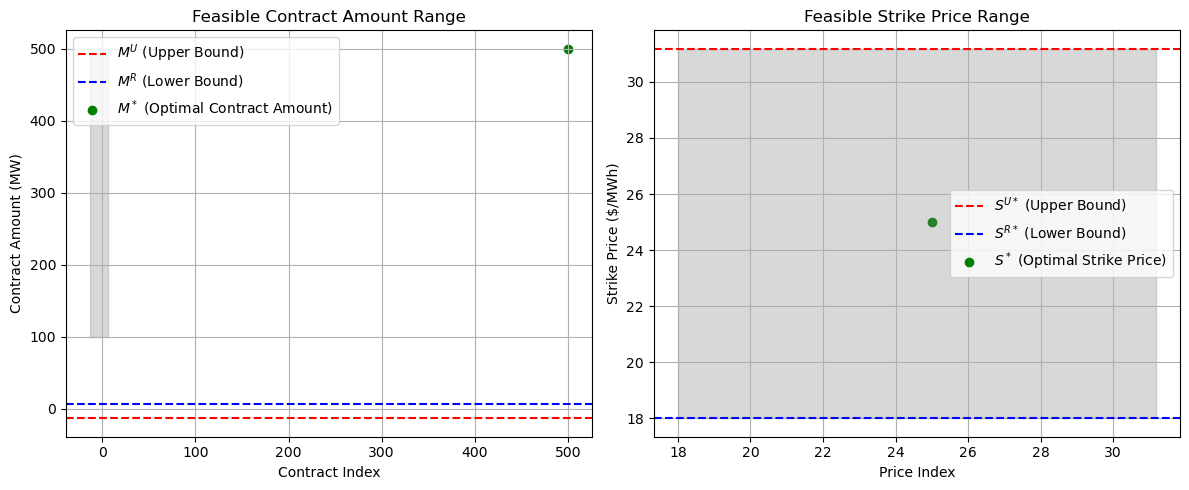

In [22]:
import matplotlib.pyplot as plt

# Data for visualization
contract_sizes = np.linspace(M_min, M_max, 100)
strike_prices = np.linspace(S_R_star, S_U_star, 100)

# Create a figure with two subplots: one for contract amount, one for strike price
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Contract amount visualization
ax[0].axhline(M_U, color='red', linestyle='--', label=r'$M^U$ (Upper Bound)')
ax[0].axhline(M_R, color='blue', linestyle='--', label=r'$M^R$ (Lower Bound)')
ax[0].scatter(Q_opt, Q_opt, color='green', label=r'$M^*$ (Optimal Contract Amount)')
ax[0].fill_betweenx(contract_sizes, M_R, M_U, color='gray', alpha=0.3)  # Feasible region
ax[0].set_xlabel("Contract Index")
ax[0].set_ylabel("Contract Amount (MW)")
ax[0].set_title("Feasible Contract Amount Range")
ax[0].legend()
ax[0].grid()

# Strike price visualization
ax[1].axhline(S_U_star, color='red', linestyle='--', label=r'$S^{U*}$ (Upper Bound)')
ax[1].axhline(S_R_star, color='blue', linestyle='--', label=r'$S^{R*}$ (Lower Bound)')
ax[1].scatter(S_opt, S_opt, color='green', label=r'$S^*$ (Optimal Strike Price)')
ax[1].fill_betweenx(strike_prices, S_R_star, S_U_star, color='gray', alpha=0.3)  # Feasible region
ax[1].set_xlabel("Price Index")
ax[1].set_ylabel("Strike Price ($/MWh)")
ax[1].set_title("Feasible Strike Price Range")
ax[1].legend()
ax[1].grid()

# Show the plot
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# Parameters (example values)
A_G = 1.0  # GenCo's risk-aversion factor
A_L = 1.0  # LSE's risk-aversion factor
zeta_1 = 100  # Threat point utility for GenCo
zeta_2 = 150  # Threat point utility for LSE
mu_lambda = 500  # Mean of lambda (sum of LMPs over contract period)
sigma_lambda = 50  # Standard deviation of lambda
T = 24  # Number of time slots (e.g., hours)
alpha = 0.95  # Confidence level for CVaR
M_lower = 0  # Lower bound for contract amount
M_upper = 600  # Upper bound for contract amount
S_lower = 15  # Lower bound for strike price
S_upper = 25  # Upper bound for strike price
num_scenarios = 1000  # Number of load scenarios
C = 10  # Production cost for GenCo ($/MWh)
retail = 30  # Retail price for LSE ($/MWh)

# Generate 1000 scenarios for lambda and load, with T time slots
np.random.seed(42)  # For reproducibility
lambda_scenarios = np.random.normal(mu_lambda, sigma_lambda, (num_scenarios, T))
load_scenarios = np.random.normal(300, 50, (num_scenarios, T))  # Example load scenarios

# Optimal production P_g[s, t] for GenCo (example: proportional to lambda)
P_g_scenarios = lambda_scenarios / mu_lambda * 300  # Example: scaled to 300 MW

# CVaR calculation for a set of scenarios
def calculate_cvar_scenarios(losses, alpha):
    """Calculate CVaR for a set of scenarios."""
    sorted_losses = np.sort(losses)
    n = len(sorted_losses)
    index = int(np.ceil(alpha * n)) - 1  # Index for the (1 - alpha) quantile
    return np.mean(sorted_losses[index:])  # Average of the worst (1 - alpha) losses

# Objective function
def objective_function(x):
    """Objective function to maximize (u_G - zeta_1) * (u_L - zeta_2)."""
    M, S = x  # Unpack decision variables

    # Initialize arrays to store utilities for each scenario
    u_G_scenarios = np.zeros(num_scenarios)
    u_L_scenarios = np.zeros(num_scenarios)

    # Loop through each scenario
    for i in range(num_scenarios):
        # Initialize earnings for this scenario
        pi_G_s = 0  # GenCo's total earnings in scenario s
        pi_L_s = 0  # LSE's total earnings in scenario s

        # Loop through each time slot
        for t in range(T):
            lambda_s_t = lambda_scenarios[i, t]
            load_s_t = load_scenarios[i, t]
            P_g_s_t = P_g_scenarios[i, t]

            # GenCo's earnings in this time slot
            pi_G_s += P_g_s_t * (lambda_s_t - C) + (S - lambda_s_t) * M

            # LSE's earnings in this time slot
            pi_L_s += load_s_t * (retail - S) + (lambda_s_t - S) * M

        # Loss functions for CVaR calculation
        loss_G = -pi_G_s  # Negative of net earnings for GenCo
        loss_L = -pi_L_s  # Negative of net earnings for LSE

        # Store utilities for this scenario
        u_G_scenarios[i] = pi_G_s - A_G * loss_G
        u_L_scenarios[i] = pi_L_s - A_L * loss_L

    # Calculate CVaR across all scenarios
    CVaR_G = calculate_cvar_scenarios(-u_G_scenarios, alpha)
    CVaR_L = calculate_cvar_scenarios(-u_L_scenarios, alpha)

    # Average utilities across all scenarios
    u_G = np.mean(u_G_scenarios)
    u_L = np.mean(u_L_scenarios)

    # Objective: maximize (u_G - zeta_1) * (u_L - zeta_2)
    return -(u_G - zeta_1) * (u_L - zeta_2)  # Negative for minimization

# Bounds for M and S
bounds = [(M_lower, M_upper), (S_lower, S_upper)]

# Initial guess for M and S
initial_guess = [300, 20]  # Example initial guess

# Constraints (if any)
# For example, you could add constraints on M and S here if needed
constraints = []  # No additional constraints in this example

# Optimize using scipy.optimize.minimize
result = minimize(
    objective_function,
    initial_guess,
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'  # Sequential Least Squares Programming
)

# Output the results
if result.success:
    optimal_M, optimal_S = result.x
    max_objective_value = -result.fun  # Negate to get the original objective value
    print(f"Optimal Contract Amount (M): {optimal_M}")
    print(f"Optimal Strike Price (S): {optimal_S}")
    print(f"Maximum Objective Value: {max_objective_value}")
else:
    print("Optimization failed:", result.message)

Optimization failed: Inequality constraints incompatible


In [8]:
import numpy as np
print(sum(np.array([1,2,3,4,5,6,7,8,9,10])*2))
print(sum(np.array([1,2,3,4,5,6,7,8,9,10]))*2)

110
110


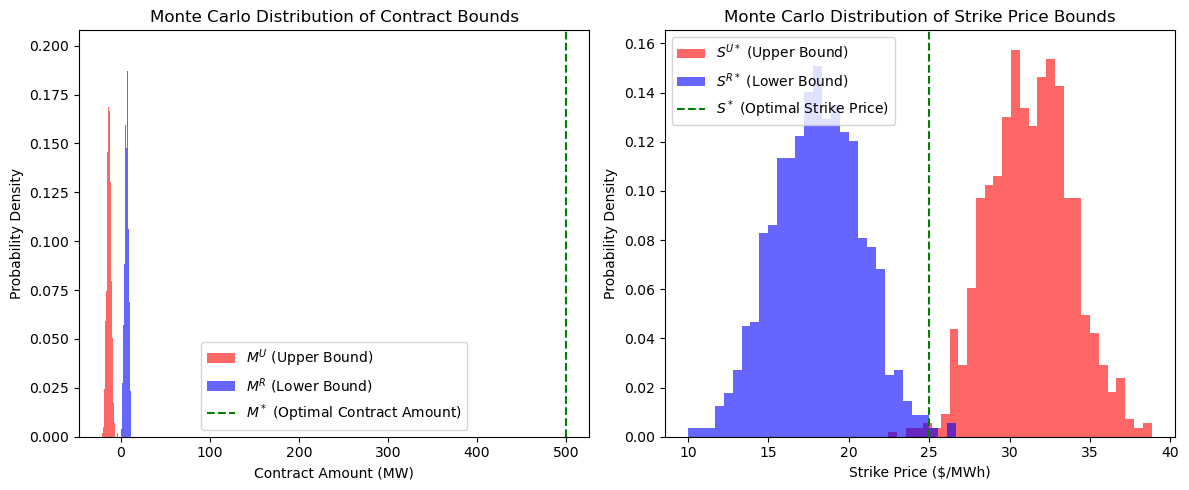

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo Simulation Parameters
num_simulations = 1000

# Generate random expected prices and CVaR values (assuming a normal distribution)
E_P_lambda_samples = np.random.normal(loc=E_P_lambda, scale=5, size=num_simulations)
CVaR_P_lambda_samples = np.random.normal(loc=CVaR_P_lambda, scale=2, size=num_simulations)
CVaR_P_neg_lambda_samples = np.random.normal(loc=CVaR_P_neg_lambda, scale=2, size=num_simulations)

# Compute Monte Carlo estimates for M_U, M_R, S_R_star, and S_U_star
M_U_samples = (A_G - A_L) / (A_L * (1 + A_G)) * E_P_lambda_samples - (A_G * (1 + A_L)) / (A_L * (1 + A_G)) * CVaR_P_lambda_samples + (1 / A_L) * K_L - (1 + A_L) / A_L * K_G + TS
M_R_samples = (A_G - A_L) / (A_L * (1 + A_G)) * E_P_lambda_samples + (A_G * (1 + A_L)) / (A_L * (1 + A_G)) * CVaR_P_neg_lambda_samples + (1 / A_L) * K_L - (1 + A_L) / A_L * K_G + TS

S_R_star_samples = np.minimum.reduce([
    (E_P_lambda_samples + A_G * CVaR_P_lambda_samples + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda_samples - A_G * CVaR_P_neg_lambda_samples + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda_samples + (1 + A_L) * K_L - A_L * CVaR_P_lambda_samples) / (1 + A_L)
])

S_U_star_samples = np.maximum.reduce([
    (E_P_lambda_samples + A_G * CVaR_P_lambda_samples + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda_samples - A_G * CVaR_P_neg_lambda_samples + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda_samples + (1 + A_L) * K_L + A_L * CVaR_P_lambda_samples) / (1 + A_L)
])

# Plot Monte Carlo results for contract amount bounds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(M_U_samples, bins=30, alpha=0.6, label=r'$M^U$ (Upper Bound)', color='red', density=True)
plt.hist(M_R_samples, bins=30, alpha=0.6, label=r'$M^R$ (Lower Bound)', color='blue', density=True)
plt.axvline(Q_opt, color='green', linestyle='--', label=r'$M^*$ (Optimal Contract Amount)')
plt.xlabel("Contract Amount (MW)")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Distribution of Contract Bounds")
plt.legend()

# Plot Monte Carlo results for strike price bounds
plt.subplot(1, 2, 2)
plt.hist(S_U_star_samples, bins=30, alpha=0.6, label=r'$S^{U*}$ (Upper Bound)', color='red', density=True)
plt.hist(S_R_star_samples, bins=30, alpha=0.6, label=r'$S^{R*}$ (Lower Bound)', color='blue', density=True)
plt.axvline(S_opt, color='green', linestyle='--', label=r'$S^*$ (Optimal Strike Price)')
plt.xlabel("Strike Price ($/MWh)")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Distribution of Strike Price Bounds")
plt.legend()

plt.tight_layout()
plt.show()


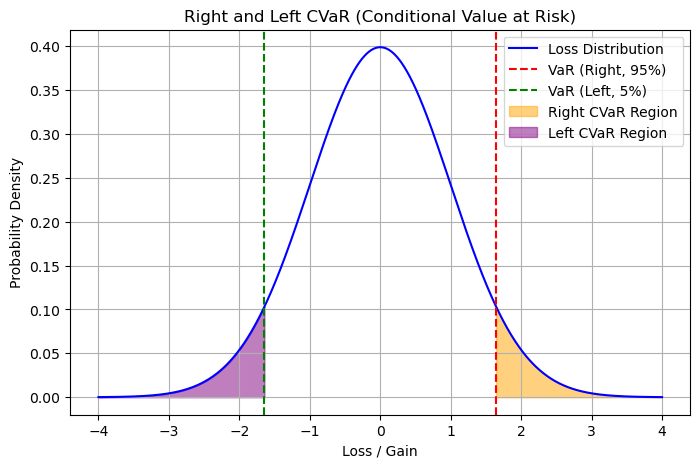

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generate a normal distribution (representing gains/losses)
mu, sigma = 0, 1  # Mean and standard deviation
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
pdf = stats.norm.pdf(x, mu, sigma)

# Define confidence level for right and left tail
confidence_level = 0.95
VaR_right = stats.norm.ppf(confidence_level, mu, sigma)  # Right-tail VaR
VaR_left = stats.norm.ppf(1 - confidence_level, mu, sigma)  # Left-tail VaR

# Define CVaR regions
x_CVaR_right = np.linspace(VaR_right, mu + 4*sigma, 500)
pdf_CVaR_right = stats.norm.pdf(x_CVaR_right, mu, sigma)

x_CVaR_left = np.linspace(mu - 4*sigma, VaR_left, 500)
pdf_CVaR_left = stats.norm.pdf(x_CVaR_left, mu, sigma)

# Plot the loss distribution
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label='Loss Distribution', color='blue')
plt.axvline(VaR_right, color='red', linestyle='--', label=f'VaR (Right, {confidence_level*100:.0f}%)')
plt.axvline(VaR_left, color='green', linestyle='--', label=f'VaR (Left, {100 - confidence_level*100:.0f}%)')
plt.fill_between(x_CVaR_right, pdf_CVaR_right, alpha=0.5, color='orange', label='Right CVaR Region')
plt.fill_between(x_CVaR_left, pdf_CVaR_left, alpha=0.5, color='purple', label='Left CVaR Region')

# Labels and legend
plt.xlabel("Loss / Gain")
plt.ylabel("Probability Density")
plt.title("Right and Left CVaR (Conditional Value at Risk)")
plt.legend()
plt.grid()

# Show the plot
plt.show()